In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Dense, MaxPooling1D, Normalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy 
from tensorflow.keras.optimizers import Adam, SGD, Nadam

In [3]:
print(tf.__version__)

2.8.0


In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
pd.unique(dataset['Origin'])

array([1, 3, 2], dtype=int64)

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2:'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

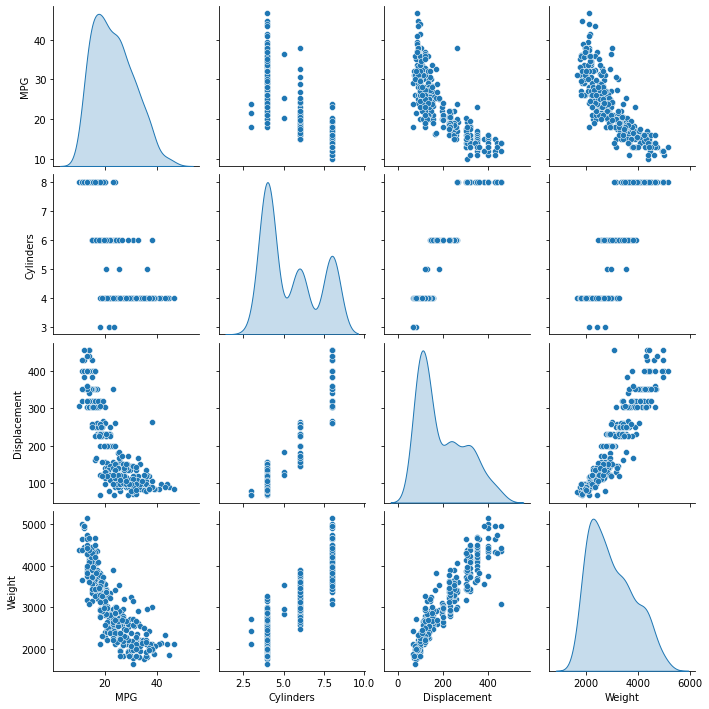

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [13]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0


In [14]:
dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [17]:
normalizer = Normalization(axis=-1)

In [18]:
normalizer.adapt(np.array(train_features))

In [19]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First example [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


under: predict only horse power

In [20]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalize = Normalization(input_shape=[1, ], axis=None)
horsepower_normalize.adapt(horsepower)

In [21]:
horsepower_model = Sequential([
    horsepower_normalize,
    Dense(1)
])
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


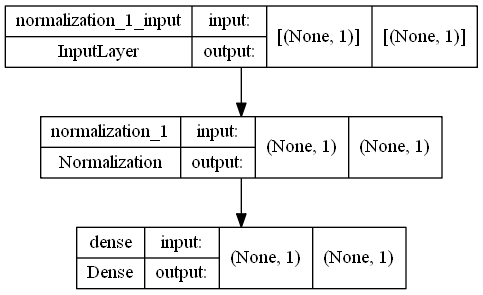

In [22]:
plot_model(horsepower_model, show_shapes=True)

In [23]:
horsepower_model.compile(optimizer=Adam(learning_rate=0.1), 
                        loss='mean_absolute_error')

In [24]:
%%time
history = horsepower_model.fit(train_features['Horsepower'], 
                              train_labels, 
                              epochs=100, 
                              verbose=0,
                              validation_split=0.2)

CPU times: total: 2.58 s
Wall time: 1.9 s


In [25]:
results = history.history

In [26]:
hist = pd.DataFrame(history.history)

In [42]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([2, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

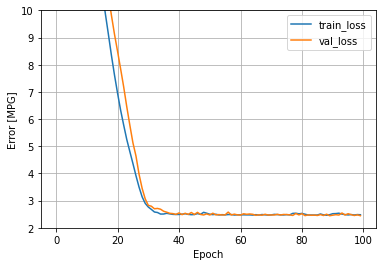

In [43]:
plot_loss(history)

In [44]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 1ms/step - loss: 3.6429


In [45]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [46]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

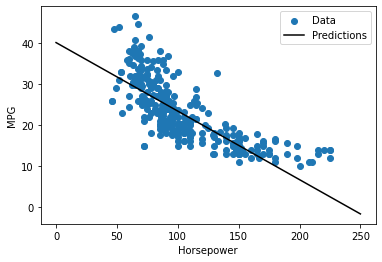

In [47]:
plot_horsepower(x, y)

Linear regression with mutiple inputs

In [48]:
linear_model = Sequential([normalizer, 
                          Dense(1)])

In [49]:
linear_model.predict(train_features[:10])

array([[-2.064],
       [-1.183],
       [ 2.055],
       [-0.7  ],
       [-0.115],
       [-0.162],
       [-0.493],
       [-2.004],
       [-0.865],
       [-1.372]], dtype=float32)

In [50]:
linear_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [51]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.531],
       [ 0.473],
       [ 0.436],
       [ 0.302],
       [-0.692],
       [ 0.68 ],
       [-0.163],
       [ 0.453],
       [-0.302]], dtype=float32)>

In [52]:
linear_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.1))

In [53]:
%%time
history = linear_model.fit(
    train_features, 
    train_labels, 
    epochs=100, 
    validation_split=0.2, 
    verbose=0)

CPU times: total: 2.66 s
Wall time: 1.79 s


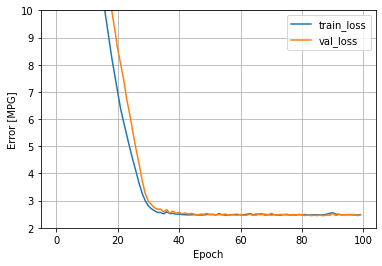

In [54]:
plot_loss(history)

In [55]:
test_results['linear_model'] = linear_model.evaluate(test_features, 
                                                    test_labels)

3/3 [==============================] - 0s 999us/step - loss: 2.5295


In [56]:
test_results

{'horsepower_model': 3.642927885055542, 'linear_model': 2.529517650604248}

In [ ]:
def build_and_compile_model(norm):
    model = Sequential([norm, 
                       Dense(64, activation='relu'),
                       Dense(64, activation='relu'),
                       Dense(1)])

model.compile(loss='mean_absolute_error',
             optimizer=)